In [92]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from rdkit import Chem
from rewards.properties import qed, SA
import tqdm

mfs = Chem.MolFromSmiles
mts = Chem.MolToSmiles

In [2]:
logRL_trajectory_dict = pickle.load(open("models/onlineRL_sim/data/LOGRL_traj_dict.pickle", 'rb'))
logRL_sim_dict = pickle.load(open("models/onlineRL_sim/data/LOGRL_sim_dict.pickle", 'rb'))

In [3]:
s_model_trajectory_dict = pickle.load(open("models/onlineRL_sim/data/s_model_traj_dict.pickle", 'rb'))
s_model_sim_dict = pickle.load(open("models/onlineRL_sim/data/s_model_sim_dict.pickle", 'rb'))

In [12]:
qs_model_trajectory_dict = pickle.load(open("models/onlineRL_sim/data/q+s_model_traj_dict.pickle", 'rb'))
qs_model_sim_dict = pickle.load(open("models/onlineRL_sim/data/q+s_model_sim_dict.pickle", 'rb'))

In [94]:
class Eval:
    def __init__(self, traj_dict, sim_dict):
        self.trajectory_dict = traj_dict
        self.all_keys = np.array(list(self.trajectory_dict.keys()))
        self.sim_dict = sim_dict
        
        self.sim_arr = np.vectorize(self.sim_dict.get)(self.all_keys)
        self.sorted_sim_arr = np.sort(self.sim_arr)[::-1]
        self.relevant_keys = {i:self.get_top_keys(i) for i in [1, 10, 100, 1000, 10000]}

    def get_qed_arr(self, relevant_keys):
        return np.array(list(map(lambda x: qed(mfs(x)), np.vectorize(self.trajectory_dict.get)(relevant_keys))))
    
    def get_SA_arr(self, relevant_keys):
        return np.array(list(map(lambda x: SA(mfs(x)), np.vectorize(self.trajectory_dict.get)(relevant_keys))))
        
    def get_metrics(self):
        for i in [1, 10, 100, 1000, 10000]:
            relevant_keys = self.relevant_keys[i]
            qed_arr = self.get_qed_arr(relevant_keys)
            mean_sim = np.mean(np.vectorize(self.sim_dict.get)(relevant_keys))
            q_min = qed_arr.min()
            q_mean = qed_arr.mean()
            q_median = np.median(qed_arr)
            q_max = qed_arr.max()
            sascore = self.get_SA_arr(relevant_keys)

            print(f"{i}\t" + "\t".join(list(map(lambda x: str(round(x, 3)), [mean_sim, q_min, q_mean, q_max, sascore.mean()]))))
            
    def get_top_keys(self, n):
        i = n
        for i in tqdm.tqdm(range(int(2*n), n, -10)):
            relevant_keys= self.all_keys[self.sim_arr >= self.sorted_sim_arr[i]]
            relevant_keys = np.array(list(filter(lambda x: len(x.split("_")) <= 5, relevant_keys)))
            relevant_smiles = np.unique(np.vectorize(self.trajectory_dict.get)(relevant_keys))
            if relevant_smiles.shape[0] < n:
                break
        relevant_keys = self.all_keys[self.sim_arr >= self.sorted_sim_arr[i+10]]
        relevant_keys = np.array(list(filter(lambda x: len(x.split("_")) <= 5, relevant_keys)))
        relevant_smiles = np.unique(np.vectorize(self.trajectory_dict.get)(relevant_keys))

        temp_set = set()
        temp_keys = []
        for key in relevant_keys:
            if self.trajectory_dict[key] in temp_set:
                continue
            temp_keys.append(key)
            temp_set.add(self.trajectory_dict[key])

        temp_sim = [self.sim_dict[key] for key in temp_keys]
        for i in range(len(temp_keys) - n):
            miny = np.argmin(temp_sim)
            temp_sim.pop(miny)
            temp_keys.pop(miny)
        
        temp_keys = np.array(temp_keys)
        assert temp_keys.shape[0] == n, "NOOOOOOO!!!!"

        return temp_keys
    
logrl_eval = Eval(logRL_trajectory_dict, logRL_sim_dict)
s_model_eval = Eval(s_model_trajectory_dict, s_model_sim_dict)
qs_model_eval = Eval(qs_model_trajectory_dict, qs_model_sim_dict)

 87%|████████████████████████████████████████████████████▉        | 868/1000 [00:37<00:05, 23.39it/s]


In [95]:
logrl_eval.get_metrics()
s_model_eval.get_metrics()
qs_model_eval.get_metrics()

1	0.791	0.262	0.262	0.262	2.251
10	0.761	0.127	0.244	0.321	2.389
100	0.704	0.088	0.294	0.624	2.334
1000	0.634	0.032	0.3	0.791	2.702
10000	0.56	0.018	0.291	0.889	3.0
1	0.694	0.289	0.289	0.289	1.967
10	0.618	0.12	0.201	0.289	2.623
100	0.554	0.049	0.206	0.712	2.858
1000	0.499	0.024	0.262	0.923	2.905
10000	0.439	0.013	0.302	0.946	2.841
1	0.703	0.294	0.294	0.294	2.171
10	0.654	0.266	0.401	0.681	2.019
100	0.59	0.102	0.299	0.681	2.412
1000	0.523	0.029	0.226	0.845	2.826
10000	0.45	0.013	0.261	0.942	2.862


In [64]:
l = {"LOGRL": logrl_eval, 
     "S model": s_model_eval,
     "Q+S model": qs_model_eval
    }
n = 10000
df = pd.concat([
    pd.DataFrame({
        "Model": [key]*n, 
        "QED": l[key].get_qed_arr(l[key].relevant_keys[n]),
        "SIM": np.vectorize(l[key].sim_dict.get)(l[key].relevant_keys[n]),
    }) for key in l
], axis=0)



In [65]:
df

,Model,QED,SIM
0,LOGRL,0.288705,0.694118
1,LOGRL,0.712130,0.532110
2,LOGRL,0.712130,0.532110
3,LOGRL,0.644113,0.602273
4,LOGRL,0.694301,0.602273
...,...,...,...
9995,Q+S model,0.325728,0.444444
9996,Q+S model,0.227699,0.434783
9997,Q+S model,0.282761,0.433962
9998,Q+S model,0.501887,0.454545


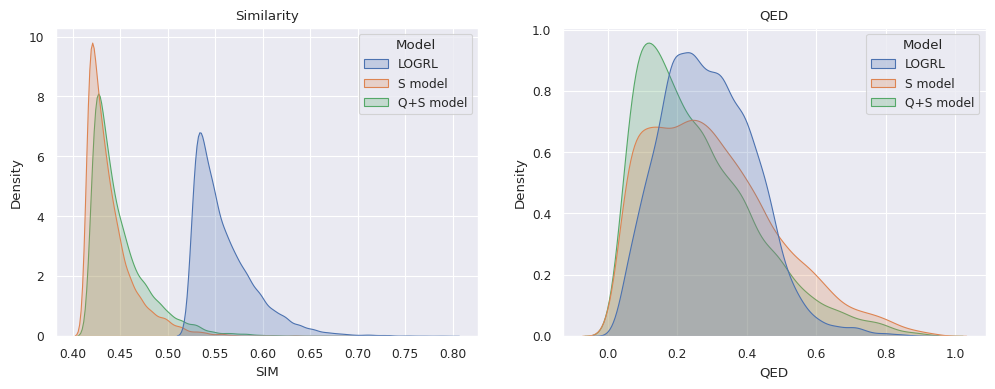

In [91]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, 
#                        sharey=True, 
                       figsize=(12, 4))

sns.kdeplot(data=df, x="SIM", hue="Model", fill=True, ax=ax[0])#, figsize=(12,6))
sns.kdeplot(data=df, x="QED", hue="Model", fill=True, ax=ax[1])

ax[0].set_title("Similarity")
ax[1].set_title("QED")
plt.show()

In [48]:
from multiprocessing import Pool

def smile_qed(s):
    return qed(mfs(s))

def all_qed(eval_model):
    arr = []
    with Pool(35) as P:
        for q in tqdm.tqdm(P.imap_unordered(smile_qed, eval_model.trajectory_dict.values(), chunksize=1000), total=eval_model.all_keys.shape[0]):
            arr.append(q)
    return np.array(arr)

qs_qed_arr = all_qed(qs_model_eval)

100%|████████████████████████████████████████████████████| 7061442/7061442 [14:01<00:00, 8391.29it/s]


In [49]:
s_qed_arr = all_qed(s_model_eval)

100%|██████████████████████████████████████████████████| 15770821/15770821 [34:18<00:00, 7662.34it/s]


In [50]:
logrl_qed_arr = all_qed(logrl_eval)

100%|██████████████████████████████████████████████████| 17026114/17026114 [36:18<00:00, 7814.58it/s]


In [70]:
np.sort(qs_qed_arr)[-10000:].mean(), np.sort(s_qed_arr)[-10000:].mean(), np.sort(logrl_qed_arr)[-10000:].mean()

(0.8650155909875451, 0.8885239068355304, 0.9173860023559189)

In [86]:
for c in [0.5, 0.6, 0.7, 0.8, 0.9]:
    print()
    print(c)
    for eval_model in [logrl_eval, s_model_eval, qs_model_eval]:
        x = eval_model.get_qed_arr(eval_model.relevant_keys[10000])
        y = eval_model.relevant_keys[10000][x>=c]
        z = np.vectorize(eval_model.sim_dict.get)(y)
        print(z.shape, z.min(), z.max(), z.mean(), z.std())


0.5
(576,) 0.5254237288135594 0.7340425531914894 0.569495983681821 0.039653691518978754
(1503,) 0.4144144144144144 0.5663716814159292 0.44059236134515445 0.024651730104610328
(974,) 0.41964285714285715 0.6666666666666666 0.44888339963345025 0.03168510341249009

0.6
(179,) 0.5254237288135594 0.7272727272727273 0.5595009612895062 0.039877702529037655
(744,) 0.4144144144144144 0.5321100917431193 0.44101287694361657 0.024345267864762637
(471,) 0.41964285714285715 0.6551724137931034 0.4464715035608934 0.030071338568585893

0.7
(73,) 0.5254237288135594 0.6521739130434783 0.5477041154081478 0.028050138775198734
(336,) 0.4144144144144144 0.5321100917431193 0.4427966389315011 0.026066662353109095
(204,) 0.41964285714285715 0.5346534653465347 0.44324092769299445 0.024671890166210943

0.8
(13,) 0.5263157894736842 0.5789473684210527 0.5480001077748023 0.015332640987854139
(115,) 0.41509433962264153 0.53125 0.4446950364758292 0.028093381856203668
(61,) 0.42 0.53125 0.4455768061714321 0.02695141190

ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set